### Generative data

The goal here is to simulate data under a generative model so that we can then try to predict the parameter values using model fitting. We will fit a linear and hierarchical linear model in pymc3 following the methods outlined here: https://twiecki.io/blog/2014/03/17/bayesian-glms-3/ and in the pymc3 tutorials. 

In [1]:
import pandas as pd
import numpy as np
import toytree
import toyplot

### The phylogeny
We will simulate data on phylogeny with four clades that have different rates of evolution of reproductive incompatibility, colored below. 

In [2]:
tree = toytree.rtree.baltree(ntips=128, treeheight=30e6)
tree = tree.mod.node_slider(prop=0.7)

In [3]:
tree.draw(
    layout='d', 
    width=500,
    tip_labels=False,
    edge_colors=tree.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

<svg class="toyplot-canvas-Canvas" height="250.0px" id="t794441d459c943079a907edad9f3ac8a" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 250.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink">

### Model 1: Linear accumulation of RI with time

We will model incompatibility as something that accumulates linearly with time since divergence, with the rate parameter varying among the four clades. The question is: "does genetic distance predict the level of genetic incompatibility between species?". To implement a hierarchical model we are additionally asking: "Does information about which clade the species are from improve estimation?"


$$ Y_{ij} = \beta_0 + (\beta_1 + \psi_i + \psi_j) X_{ij} + e $$

$ \beta_0$ = intercept    
$ \beta_1$ = slope  
$ X_{ij}$ = genetic divergence  
$ Y_{ij}$  = Reproductive incompatibility  
$ \psi$ = velocity of RI which interacts additively with other species $\psi$ to generate RI between a cross. A $\psi$>0 accumulates RI faster than average after controlling for genetic distance while a $\psi$<0 accumulates slower. 

In [4]:
# True param values
b0 = 0.01
b1 = 1.0 / 19e6
err = 0.15

In [5]:
# nodes at the crown of four major clades in the tree
velocities = {
    248: b1 / 2,     # fastest rate of RI (red)
    251: b1 / 5,     # fast rate of RI (orange)
    250: -b1 / 5,    # slow rate of RI (green)
    249: -b1 / 3,    # slowest rate of RI (blue)
}

In [6]:
# build full dictionary of velocities
allvelo = {}

# iterate over dictionary keys
for node in velocities:
    
    # get all descendants of the selected node
    idxs = tree.get_node_descendant_idxs(node)
    
    # update dictionary mapping velo to node
    allvelo.update({i: velocities[node] for i in idxs})

# set velocities on nodes of the tree
tree = tree.set_node_values("velocity", allvelo)

In [8]:
# assign clade color attribute to each node
for node, color in zip(velocities, toytree.colors[:4]):
    for idx in tree.get_node_descendant_idxs(node):
        tree.idx_dict[idx].color = color

### A function to get genetic distnace between nodes

In [9]:
def dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

### Fill a sparse data frame with RI values (*sensu* literature search)
To emulate real data we will collect random crosses between both closely related and distantly related species. 

In [10]:
np.random.seed(123)
ncrosses = 1000

# randomly choose tip idx numbers maternal and paternal
data = pd.DataFrame({
    "maternal": np.random.randint(0, tree.ntips, ncrosses),
    "paternal": np.random.randint(0, tree.ntips, ncrosses),
    "RI": np.zeros(ncrosses),
})

# iterate to fill RI values
for idx in data.index:
    
    # get node indices
    idx0 = data.loc[idx, "maternal"]
    idx1 = data.loc[idx, "paternal"]
    
    # get node velocities
    v0 = tree.idx_dict[idx0].velocity
    v1 = tree.idx_dict[idx1].velocity
    
    # generate error
    error = np.random.normal(0, err)
    
    # get RI
    ri = b0 + ((b1 + v0 + v1) * (dist(tree, idx0, idx1) / 2.0)) + error
    
    # normalize -- cannot be >1 or <0
    ri = max(0.0, min(1.0, ri))
    
    # store values
    data.loc[idx, "RI"] = ri
    data.loc[idx, "divtime"] = dist(tree, idx0, idx1) / 2.

# show 
data.head()

,maternal,paternal,RI,divtime
0,126,22,1.000000,3.000000e+07
1,109,39,1.000000,3.000000e+07
2,126,63,1.000000,3.000000e+07
3,66,71,0.181746,1.196749e+07
4,92,13,1.000000,3.000000e+07


### Final data

Drop data points where the maternal and paternal organisms are the same one, since we randomly selected them. Then log transform the divergence time estimates to make for prettier plotting and simpler model fitting. 

In [20]:
fdata = data.drop(index=data[data.maternal == data.paternal].index)

In [21]:
fdata["logdiv"] = np.log(fdata["divtime"])

In [22]:
canvas = toyplot.Canvas(width=400, height=300)
axes = canvas.cartesian(
    xlabel="Divergence time",
    ylabel="Reprod. incomp.",
)
axes.scatterplot(
    fdata.divtime,
    fdata.RI,
    size=8,
    opacity=0.2,
    color=[tree.idx_dict[i].color for i in fdata.maternal],
);
axes.x.ticks.show = True
axes.y.ticks.show = True

<svg class="toyplot-canvas-Canvas" height="300.0px" id="td4b48606fd244a89a2d0249d6724734a" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <g class="toyplot-Datum" style="fill:rgb(90.6%,54.1%,76.5%);fill-opacity:1.0;opacity:0.2;stroke:rgb(90.6%,54.1%,76.5%);st

In [23]:
fdata.describe()

,maternal,paternal,RI,divtime,logdiv
count,995.000000,995.000000,995.000000,9.950000e+02,995.000000
mean,65.828141,62.365829,0.907005,2.617828e+07,17.039549
std,37.565176,37.307613,0.207195,5.638217e+06,0.342013
min,0.000000,0.000000,0.000000,1.482167e+06,14.209016
25%,32.000000,29.000000,1.000000,2.600289e+07,17.073718
50%,68.000000,61.000000,1.000000,3.000000e+07,17.216708
75%,99.000000,95.000000,1.000000,3.000000e+07,17.216708
max,127.000000,127.000000,1.000000,3.000000e+07,17.216708


### Pairwise RI heatmap of OBSERVED DATA

In [24]:
# colormap for values between 0-1
cmap = toyplot.color.LinearMap(domain_min=0, domain_max=1.0)
cmap

In [25]:
canvas = toyplot.Canvas(width=600, height=600);

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 225, 45, 555), show=False)
tree.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=tree.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

# add heatmap to canvas
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550))
for ridx in range(128):
    for cidx in range(128):
        
        # get RI for this cell
        d0 = data[(data.maternal == ridx) & (data.paternal == cidx)]
        d1 = data[(data.paternal == ridx) & (data.maternal == cidx)]
        
        if d0.size:
            col = cmap.color(d0.iloc[0, 2])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }
        elif d1.size:
            col = cmap.color(d1.iloc[0, 2])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }           
        else:
            # set style
            ax1.cells.cell[ridx, cidx].style = {
                "fill": "lightgrey", "stroke": "none"
            }
ax1.body.gaps.columns[...] = 1
ax1.body.gaps.rows[...] = 1

# add a colorbar to canvas
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

<svg class="toyplot-canvas-Canvas" height="600.0px" id="t86f9cbfdaa7b4034b3c7a5eb746ffeec" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 600.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <rect heig

### (HYPOTHETICAL) PAIRWISE HEATMAP OF INFERRED RI

After applying our hierarchical linear regression to estimate clade-specific rates of RI accumulation we can now estimate the RI between all species pairs based on the clade they belong to and the genetic distance between them. 

In [ ]:
canvas = toyplot.Canvas(width=600, height=600);

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 225, 45, 555), show=False)
tree.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=tree.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

# add heatmap
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550))
for ridx in range(128):
    for cidx in range(128):

        # get node velocities
        v0 = tree.idx_dict[ridx].velocity
        v1 = tree.idx_dict[cidx].velocity

        # generate error
        error = np.random.normal(0, err)

        # get RI
        ri = b0 + ((b1 + v0 + v1) * (dist(tree, ridx, cidx) / 2.0)) + error

        # normalize -- cannot be >1 or <0
        col = cmap.color(ri)
        ax1.cells.cell[ridx, cidx].style = {
            "fill": col, "stroke": "none"
        }
    
# dividers
ax1.body.gaps.columns[...] = 1
ax1.body.gaps.rows[...] = 1

# add a colorbar
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

### TODO: MODEL FITTING

### Individual model
This model tries to fit a single intercept and slope to the RI data. 

In [128]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [201]:
with pm.Model() as m0:
    
    # model parameters
    b0 = pm.Normal("alpha", mu=0, sd=1)
    b1 = pm.Normal("beta", mu=15, sd=5)
    er = pm.HalfCauchy("err", beta=1)
    
    # linear model
    ri = b0 + b1 * fdata["logdiv"]
    
    # the data likelihoood w/ normally distributed error...
    # but it should be MVN distributed...
    y_lik = pm.Normal("lik", mu=ri, sd=er, observed=fdata.RI)

    # inference
    trace = pm.sample(tune=10000, draws=10000);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [err, beta, alpha]
Sampling 4 chains, 0 divergences:   2%|▏         | 1507/80000 [00:03<02:37, 497.55draws/s] 


RuntimeError: Chain 3 failed.

/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


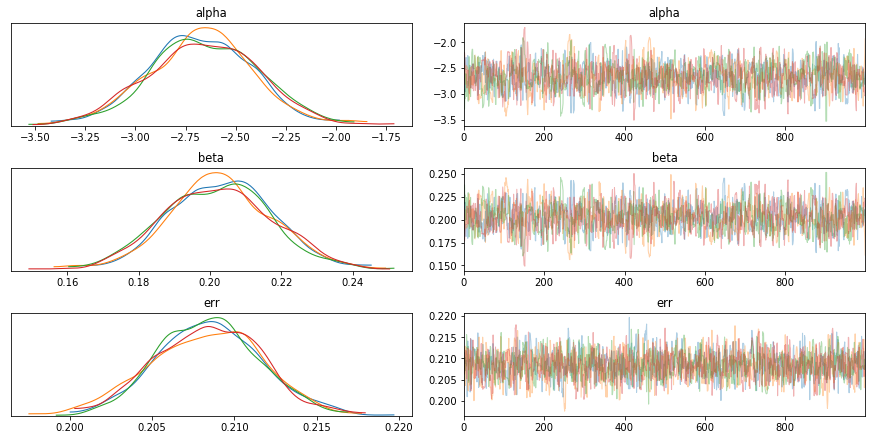

In [106]:
pm.traceplot(trace);

In [ ]:
# takes about 45 minutes
indiv_traces = {}

for county_name in county_names:
    
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace